## Create the two loops

In [7]:
import sys
import sys
import os
ROOT  = "../"
# Add current working directory to sys.path
sys.path.append(ROOT)
sys.path.append("/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/")
from PointList import *
%matplotlib widget 
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from _3DLoops._3dpu_using_dfs import *
from Block_edges.block_edges import *
import sys
sys.path.append("/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/MIP_constraints/Python/")
from CreatingCycles import *

## The two loops

In [8]:
def loop_create(r,O, num_points):
    xo,yo,zo = O
    points = PointList()
    for n in tqdm(range(num_points)):
        theta = n * 2 * math.pi / num_points
        x = r * math.cos(theta) + xo
        y = r * math.sin(theta) + yo
        points.add_point((x,y,zo))
    return points

## Fill in the said loop

In [9]:
r,h = 4,2

points1 = loop_create(r,(0,0,0.5), 100)
points2 = loop_create(r,(0,0,h + 0.5), 100)

loops = [points1,points2]
List_M = []
List_edges = []

for loop in loops:
    M = Edge_Flipping(loop,10*len(loop.points))
    M.create_quadrilaterals()
    M.split_quadrilateral()
    M.canonic_representation_from_mesh()
    M.clean_triangles()
    M.fill_edges()
    M.update_weights()
    M.mapping = [np.array(o) for o in M.mapping]
    List_M.append(M)
    E = Block_edges(M.triangles,M.mapping)
    E.block_all_the_edges()
    List_edges.append(E.blocked_edges)

100%|██████████| 100/100 [00:00<00:00, 565270.08it/s]


s is 4


100%|██████████| 900/900 [00:01<00:00, 475.24it/s]


s is 4


100%|██████████| 900/900 [00:01<00:00, 467.49it/s]


In [13]:
# epsilon = 0.01
# List_edges = []
# for M in List_M:
#     area = M.calculate_area()
#     print(len(M.triangles))
#     for i in tqdm(M.inside_indexes):
#         M.update_mapping(i)
#     D = M.lawson_flip()
#     new_area = M.calculate_area()
#     print(new_area,area - new_area,M.compute_mean_curvature(),M.vertex_curvatures[M.compute_mean_curvature()])
#     while  area - new_area > epsilon:
#         area = M.calculate_area()
#         M.update_weights()
#         for i in tqdm(M.inside_indexes):
#             M.update_mapping(i)
#         M.lawson_flip()
#         new_area = M.calculate_area()
#     E = Block_edges(M.triangles,M.mapping)
#     E.block_all_the_edges()
#     List_edges.append(E.blocked_edges)


900


100%|██████████| 401/401 [00:00<00:00, 43150.39it/s]
1517it [00:00, 45656.34it/s]            
1412it [00:00, 50194.57it/s]            
100%|██████████| 1400/1400 [00:00<00:00, 52577.14it/s]

113.02293515276412

 -1.2363443602225743e-12 1.3087478735244698e-09 127


100%|██████████| 900/900 [00:02<00:00, 350.89it/s]


900


100%|██████████| 401/401 [00:00<00:00, 41735.92it/s]
1504it [00:00, 46192.84it/s]            
1411it [00:00, 51880.94it/s]            
1402it [00:00, 52492.92it/s]            
100%|██████████| 1400/1400 [00:00<00:00, 52067.12it/s]


113.02293515276396 -1.0800249583553523e-12 2.974279831351871e-11 346


100%|██████████| 900/900 [00:02<00:00, 317.80it/s]


In [12]:
Edges = []
for list_edges in tqdm(List_edges):
    for edge in list_edges:
        Edges.append([list(edge[0]),list(edge[1])])

        
Edges = set([tuple((tuple(edge[0]),tuple(edge[1]))) for edge in Edges])
Edges = list(Edges)
G = GraphGrid3D(Edges,[])

100%|██████████| 2/2 [00:00<00:00, 1118.78it/s]


In [13]:
len(Edges)

98

In [6]:
import pickle
# Specify the path to the pickle file
filepath = 'marked_edges.pickle'

# Load the edges from the pickle file
with open(filepath, 'rb') as f:
    Marked_edges = pickle.load(f)


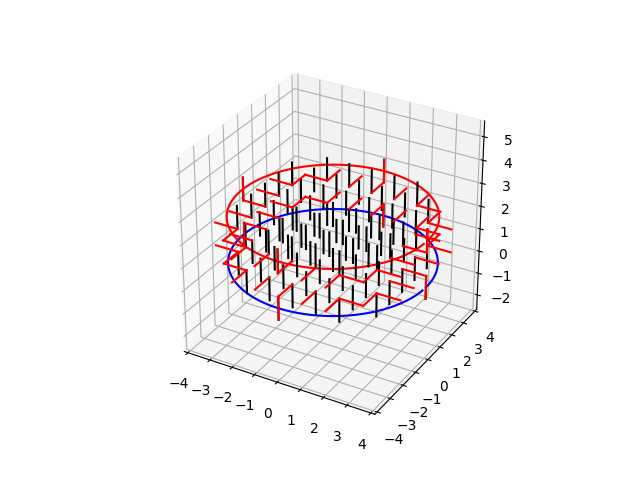

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

X = []
Y = []
Z = []

# Draw loop of points
for point in points1.points:
    x, y, z = point
    X.append(x)
    Y.append(y)
    Z.append(z)

ax.plot(X, Y, Z, color='b')

X1,Y1,Z1 = [],[],[]

for point in points2.points:
    x, y, z = point
    X1.append(x)
    Y1.append(y)
    Z1.append(z)
ax.plot(X1, Y1, Z1, color='red')


A,B,C = [],[],[]

# for point in cycle:
#     x, y, z = G.mapping[point]
#     A.append(x)
#     B.append(y)
#     C.append(z)
# ax.plot(A, B, C, color='green')

# for cycle in cycles[110:111]:
#     A,B,C = [],[],[]
#     for point in cycle:
#         x, y, z = G.mapping[point]
#         A.append(x)
#         B.append(y)
#         C.append(z)
#     ax.plot(A, B, C, color='green')
# cycle = cycles[110]
# Blockii_edges = []
# for i in range(len(cycle)):
#     edge = min(cycle[i],cycle[(i+1)%len(cycle)]),max(cycle[i],cycle[(i+1)%len(cycle)])

#     Blockii_edges.append(edge)
    
# for edge in Blockii_edges:
#     x,y,z = G.mapping[edge[0]]
#     x1,y1,z1 = G.mapping[edge[1]]
#     ax.plot([x,x1],[y,y1],[z,z1],color="black")

for edge in Edges:
    ax.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]],[edge[0][2],edge[1][2]],color='black')
    
Marked_edges = [[(-4, -1, 1), (-3, -1, 1)], [(-4, -2, 1), (-3, -2, 1)], [(-1, 3, 2), (-1, 4, 2)], [(3, -2, 1), (4, -2, 1)], [(-3, -3, 2), (-2, -3, 2)], [(-3, -3, 1), (-3, -2, 1)], [(-4, 0, 0), (-4, 0, 1)], [(-2, 3, 2), (-2, 4, 2)], [(2, 3, 1), (3, 3, 1)], [(4, 0, 0), (4, 0, 1)], [(3, 1, 1), (4, 1, 1)], [(-2, -4, 1), (-2, -3, 1)], [(3, 2, 1), (3, 3, 1)], [(-1, 3, 1), (-1, 4, 1)], [(0, -4, 2), (0, -4, 3)], [(-4, 1, 2), (-3, 1, 2)], [(2, 3, 2), (2, 4, 2)], [(4, 0, 2), (4, 0, 3)], [(1, 3, 2), (1, 4, 2)], [(3, -3, 2), (3, -2, 2)], [(-4, -2, 2), (-3, -2, 2)], [(3, 1, 2), (4, 1, 2)], [(-3, -3, 2), (-3, -2, 2)], [(-3, 3, 2), (-2, 3, 2)], [(3, 2, 1), (4, 2, 1)], [(3, 2, 2), (3, 3, 2)], [(0, -4, 0), (0, -4, 1)], [(3, -1, 1), (4, -1, 1)], [(-3, 2, 2), (-3, 3, 2)], [(3, -1, 2), (4, -1, 2)], [(3, -3, 1), (3, -2, 1)], [(-4, 1, 1), (-3, 1, 1)], [(-4, 2, 1), (-3, 2, 1)], [(-4, 0, 1), (-3, 0, 1)], [(2, -3, 2), (3, -3, 2)], [(1, 3, 1), (1, 4, 1)], [(3, 2, 2), (4, 2, 2)], [(3, 0, 2), (4, 0, 2)], [(2, -4, 2), (2, -3, 2)], [(0, -4, 1), (0, -3, 1)], [(-3, 2, 1), (-3, 3, 1)], [(-1, -4, 2), (-1, -3, 2)], [(3, -2, 2), (4, -2, 2)], [(0, -4, 2), (0, -3, 2)], [(-3, 3, 1), (-2, 3, 1)], [(0, 3, 2), (0, 4, 2)], [(1, -4, 2), (1, -3, 2)], [(3, 0, 1), (4, 0, 1)], [(-2, 3, 1), (-2, 4, 1)], [(-4, 2, 2), (-3, 2, 2)], [(2, -3, 1), (3, -3, 1)], [(0, 4, 2), (0, 4, 3)], [(-4, -1, 2), (-3, -1, 2)], [(-3, -3, 1), (-2, -3, 1)], [(-4, 0, 2), (-4, 0, 3)], [(2, -4, 1), (2, -3, 1)], [(-2, -4, 2), (-2, -3, 2)], [(2, 3, 1), (2, 4, 1)], [(0, 4, 0), (0, 4, 1)], [(1, -4, 1), (1, -3, 1)], [(-1, -4, 1), (-1, -3, 1)], [(2, 3, 2), (3, 3, 2)], [(-4, 0, 2), (-3, 0, 2)], [(0, 3, 1), (0, 4, 1)]]

for edge in Marked_edges:
    ax.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]],[edge[0][2],edge[1][2]],color='red')

# for point in Points:
#     for point2 in  Points:
#         if point != point2:
#             ax.plot([point[0],point2[0]],[point[1],point2[1]],[point[2],point2[2]],color='green')
#             X.append(point[0])
#             Y.append(point[1])
#             Z.append(point[2])

X = np.concatenate((X,X1))
Y = np.concatenate((Y,Y1))
Z = np.concatenate((Z,Z1))

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()


In [15]:

file_path = "/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/scripts_folder/r.4__h.3_all/Marked_edges.txt"

with open(file_path, "r") as file:
    text = file.read()

In [17]:
import re

pattern1 = "le temps d'execution est (\d+)"
pattern2 = "le nombre de marked edges est (\d+)"
pattern3 = "le nombre de cycles est (\d+)"

numbers__of_cycles = re.findall(pattern3, text)
number_of_marked_edges = re.findall(pattern2, text)
execution_time = re.findall(pattern1, text)

# Conversion des nombres trouvés en entiers

numbers__of_cycles = [int(number) for number in numbers__of_cycles]
number_of_marked_edges = [int(number) for number in number_of_marked_edges]
execution_time = [int(number) for number in execution_time]


print(execution_time)

[0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 7, 6, 9, 12, 9, 10, 60, 17, 52, 78, 73, 165, 187, 961, 393, 502, 1752, 1464, 1482, 647, 2795, 1797, 1946, 3762, 3029, 10593, 6694, 26885, 33984, 31826]


In [43]:
G = GraphGrid3D(Edges,[])
x_min,x_max,y_min,y_max,z_min,z_max = G.x_min,G.x_max,G.y_min,G.y_max,G.z_min,G.z_max
Points = []
for i in [x_min,x_max]:
    for j in [y_min,y_max]:
        for k in [z_min,z_max]:
            Points.append((i,j,k))

In [30]:
GC = Graph_Cycles(Edges,Marked_edges)
len(next(iter(GC.b_1)))
L = [len(cycle) for cycle in GC.b_1]
indice1 = np.argmin(L)
indice2 = np.argmax(L)
cycle2 = list(GC.b_1)[indice2]
cycle1 = list(GC.b_1)[indice1]
len(cycle2)

433

## Gurobi Model

In [16]:
import sys
sys.path.append("/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/MIP_constraints/Python/")
from CreatingCycles import *

## Filling the MIP for problem constraints

In [17]:
Blocked_edges = Edges
Marked_edges = Edges[:-1]
GC = Graph_Cycles(Blocked_edges,Marked_edges)
print(len(Marked_edges))
len(Blocked_edges) - len(Marked_edges)

100%|██████████| 356/356 [00:00<00:00, 8767.69it/s]

9


1

In [16]:
def find_cycle_impair(GC):
    path = nx.shortest_path(GC.Graph_cycles,0,1)
    tried_paths = set()
    while not GC.get_full_cycle(path) and tuple(path) not in tried_paths:
        cpt1 = np.random.randint(0,len(GC.dict_blocked_edges))
        blocked_edge = list(GC.dict_blocked_edges.keys())[cpt1]
        cycle_blocked = GC.dict_blocked_edges[blocked_edge]
        if len(cycle_blocked) == 0:
            print("---------------------")
            print(cpt1)
            print("--------------------")
        cycle_blocked_index = GC.cycles_index[cycle_blocked[np.random.randint(0,len(cycle_blocked))]]
        cycle_index = np.random.randint(0,len(GC.cycles))
        tried_paths.add(tuple(path))
        path = nx.shortest_path(GC.Graph_cycles,cycle_index,cycle_blocked_index)
    return GC.get_full_cycle(path)

In [32]:
import pickle

# Specify the path to the pickle file
filepath = '/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/scripts_folder/r.3_h.6/cycles.pkl'

# Load the cycles from the pickle file
with open(filepath, 'rb') as f:
    cycles = pickle.load(f)


In [28]:
def resolve_MIP(cycles,Blocked_edges,Marked_edges):
    problem = pulp.LpProblem("Graph Problem", pulp.LpMinimize)
    GC = Graph_Cycles(Blocked_edges,Marked_edges)
    G = GraphGrid3D(Blocked_edges,[])
    # Define the decision variables
    x = pulp.LpVariable.dicts("x", G.edges, cat=pulp.LpBinary)

    # Define the objective function
    problem += pulp.lpSum([x[i] for i in G.edges])

    # detect a constraints
    new_cycles = GC.b_1
    for cycle in new_cycles:
        cycles.append(cycle)
    E = []
    for cycle in tqdm(cycles):
        edges = []
        for point in range(len(cycle)-1):
            node = cycle[point]
            next_node = cycle[(point+1)]
            edge = (min(node,next_node),max(node,next_node))
            edges.append(edge)
        E.append(edges)
    print(E)
    for edge in E:

        problem += pulp.lpSum(x[i] for i in edge) >= 1

    # Solve the MIP problem
    print("begin solving")
    problem.solve(pulp.PULP_CBC_CMD())
    
    # Print the optimal solution
    print("Optimal Solution:")
    new_marked = []
    for i in G.edges:
        if pulp.value(x[i]) == 1:
            n,m = i
            new_marked.append([G.mapping[n],G.mapping[m]])
    # Print the objective value
    print("Objective Value:", pulp.value(problem.objective))
    return cycles,new_marked

In [38]:
import pulp as pl
solver_list = pl.listSolvers(onlyAvailable=True)
print(solver_list)

['GLPK_CMD', 'PYGLPK', 'CPLEX_CMD', 'CPLEX_PY', 'GUROBI', 'GUROBI_CMD', 'MOSEK', 'XPRESS', 'XPRESS', 'XPRESS_PY', 'PULP_CBC_CMD', 'COIN_CMD', 'COINMP_DLL', 'CHOCO_CMD', 'MIPCL_CMD', 'SCIP_CMD', 'FSCIP_CMD', 'SCIP_PY', 'HiGHS', 'HiGHS_CMD', 'COPT', 'COPT_DLL', 'COPT_CMD']


In [34]:
Blocked_edges = Edges
Marked_edges = [[(-2, -6, 3), (-2, -6, 4)], [(1, -6, 4), (1, -5, 4)], [(-1, 5, 1), (-1, 6, 1)], [(-5, -3, 0), (-5, -3, 1)], [(-6, 2, 1), (-5, 2, 1)], [(-5, -2, 0), (-5, -2, 1)], [(1, 5, 0), (1, 5, 1)], [(2, -6, 1), (2, -5, 1)], [(2, -1, -1), (2, 0, -1)], [(-5, 3, 0), (-5, 3, 1)], [(-6, -1, 3), (-6, -1, 4)], [(2, 5, 3), (2, 5, 4)], [(-3, 5, 0), (-3, 5, 1)], [(-1, -6, 0), (-1, -6, 1)], [(-1, 5, 3), (-1, 6, 3)], [(-5, -3, 3), (-5, -3, 4)], [(0, -6, 0), (0, -6, 1)], [(5, 4, 0), (5, 4, 1)], [(-3, 5, 3), (-3, 5, 4)], [(0, -6, 3), (0, -6, 4)], [(5, -2, -1), (6, -2, -1)], [(-5, -1, 0), (-5, -1, 1)], [(5, 3, 3), (5, 3, 4)], [(5, -2, 1), (6, -2, 1)], [(5, 4, 3), (5, 4, 4)], [(3, 5, 3), (3, 5, 4)], [(4, -4, 0), (4, -4, 1)], [(2, 4, -1), (2, 5, -1)], [(-5, -3, 0), (-4, -3, 0)], [(-5, -2, 3), (-5, -2, 4)], [(-6, 3, 3), (-5, 3, 3)], [(6, 0, 3), (6, 0, 4)], [(-6, 0, 4), (-6, 0, 5)], [(-5, 4, 3), (-5, 4, 4)], [(4, 3, 3), (5, 3, 3)], [(-6, 7, 5), (-5, 7, 5)], [(3, -5, 0), (3, -5, 1)], [(-5, 1, 0), (-5, 1, 1)], [(6, -1, 0), (6, -1, 1)], [(5, -1, 2), (6, -1, 2)], [(5, -5, 3), (5, -4, 3)], [(-2, 6, 0), (-2, 6, 1)], [(-6, 3, 2), (-5, 3, 2)], [(-6, 0, 0), (-6, 0, 1)], [(3, 7, 3), (3, 7, 4)], [(5, -3, 3), (6, -3, 3)], [(1, 5, 4), (1, 6, 4)], [(5, 2, 1), (6, 2, 1)], [(-3, -5, 0), (-3, -5, 1)], [(0, 5, 2), (0, 5, 3)], [(-2, -6, 1), (-2, -5, 1)], [(-4, 4, 0), (-4, 4, 1)], [(5, -2, 3), (6, -2, 3)], [(5, 3, 1), (6, 3, 1)], [(-6, 2, 3), (-6, 2, 4)], [(-5, 4, 1), (-5, 4, 2)], [(-2, -7, 3), (-2, -7, 4)], [(6, 1, 3), (6, 1, 4)], [(-7, 2, 3), (-7, 2, 4)], [(5, -1, 4), (6, -1, 4)], [(-6, 0, 1), (-5, 0, 1)], [(7, -2, 0), (7, -1, 0)], [(2, 5, 0), (2, 5, 1)], [(4, 4, 4), (4, 5, 4)], [(6, 2, 3), (6, 2, 4)], [(4, 4, 4), (5, 4, 4)], [(4, -5, -1), (4, -5, 0)], [(1, -6, 0), (1, -5, 0)], [(-3, -5, 3), (-3, -5, 4)], [(-5, 3, 0), (-5, 4, 0)], [(-1, 4, 3), (0, 4, 3)], [(0, -7, 0), (0, -7, 1)], [(-5, 3, 1), (-4, 3, 1)], [(6, 0, 1), (7, 0, 1)], [(3, -4, 0), (3, -4, 1)], [(-2, 5, 0), (-2, 5, 1)], [(1, -6, 2), (1, -5, 2)], [(5, -3, 0), (5, -3, 1)], [(-4, -6, -1), (-3, -6, -1)], [(0, 6, 0), (0, 6, 1)], [(6, 1, 0), (6, 1, 1)], [(-3, -7, 1), (-2, -7, 1)], [(2, -6, 3), (2, -5, 3)], [(-7, 6, 0), (-6, 6, 0)], [(3, 3, 4), (3, 3, 5)], [(4, -5, 3), (4, -4, 3)], [(4, -2, 1), (4, -2, 2)], [(0, 6, 3), (0, 6, 4)], [(-4, -5, 4), (-4, -5, 5)], [(-1, -6, 2), (-1, -5, 2)], [(-4, 4, 4), (-4, 5, 4)], [(5, 1, 4), (6, 1, 4)], [(2, 4, 2), (3, 4, 2)], [(3, 1, 2), (4, 1, 2)], [(3, -5, 3), (3, -5, 4)], [(-5, 1, 3), (-5, 1, 4)], [(3, 5, 0), (3, 5, 1)], [(-4, -4, 0), (-4, -4, 1)], [(4, 4, 0), (4, 4, 1)], [(5, -4, 3), (5, -4, 4)], [(0, -7, 3), (0, -7, 4)], [(7, 7, 1), (7, 7, 2)]]
cycles = cycles
GC = Graph_Cycles(Blocked_edges,Marked_edges)
while GC.b_1 :
    GC = Graph_Cycles(Blocked_edges,Marked_edges)
    cycles,new_marked = resolve_MIP(cycles,Blocked_edges,Marked_edges)
    Marked_edges = new_marked

/home/mehdii/.local/lib/python3.11/site-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
100%|██████████| 9436/9436 [00:00<00:00, 16994.79it/s]


begin solving


KeyboardInterrupt: 

(1.0, 5.0)

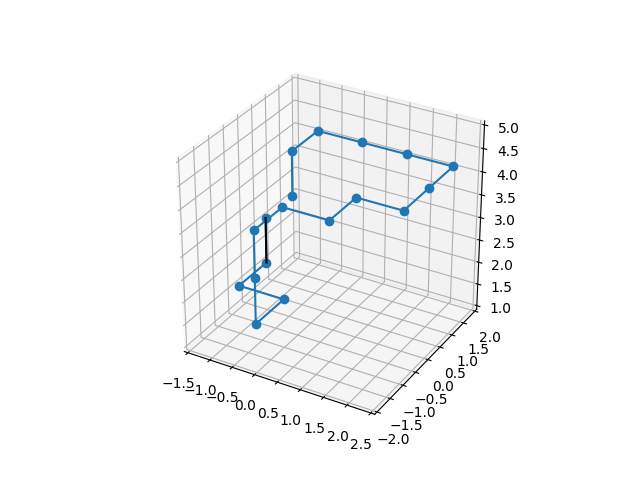

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
X,Y,Z = [],[],[]
cpt1 = np.random.randint(0,len(GC.dict_blocked_edges))
blocked_edge = list(GC.dict_blocked_edges.keys())[cpt1]
cycle_blocked = GC.dict_blocked_edges[blocked_edge]
cycle = cycle_blocked[np.random.randint(0,len(cycle_blocked))]
# for cycle in GC.dict_blocked_edges[(62, 63)]:
A,B,C = [],[],[]
for point in cycle:
    x, y, z = G.mapping[point]
    A.append(x)
    B.append(y)
    C.append(z)
    ##########
    X.append(x)
    Y.append(y)
    Z.append(z)

ax.plot(A, B, C,marker = "o") 

Blockii_edges = []
for i in range(len(cycle)):
    edge = min(cycle[i],cycle[(i+1)%len(cycle)]),max(cycle[i],cycle[(i+1)%len(cycle)])
    if edge in G.blocked_edges:
        Blockii_edges.append(edge)
    
for edge in Blockii_edges:
    x,y,z = G.mapping[edge[0]]
    x1,y1,z1 = G.mapping[edge[1]]
    ax.plot([x,x1],[y,y1],[z,z1],color="black")


# origin = 180
# x,y,z = G.mapping[origin]
# ax.plot(x,y,z,color="black",marker="x")

X,Y,Z = np.array(X),np.array(Y),np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

## Resolving the MIP problem

In [9]:
import pulp

# Create a MIP problem
def resolve_MIP(cycles,Blocked_edges,Marked_edges):
    problem = pulp.LpProblem("Graph Problem", pulp.LpMinimize)
    GC = Graph_Cycles(Blocked_edges,Marked_edges)
    G = GraphGrid3D(Blocked_edges,[])
    # Define the decision variables
    x = pulp.LpVariable.dicts("x", G.edges, cat=pulp.LpBinary)

    # Define the objective function
    problem += pulp.lpSum([x[i] for i in G.edges])

    # detect a constraints
    cycle = find_cycle_impair(GC)
    cycles.append(cycle)
    E = []
    for cycle in cycles:
        edges = []
        for point in range(len(cycle)-1):
            node = cycle[point]
            next_node = cycle[(point+1)]
            edge = (min(node,next_node),max(node,next_node))
            edges.append(edge)
        E.append(edges)

    for edge in E:

        problem += pulp.lpSum(x[i] for i in edge) >= 1

    # Solve the MIP problem
    problem.solve(pulp.PULP_CBC_CMD())
    
    # Print the optimal solution
    print("Optimal Solution:")
    new_marked = []
    for i in G.edges:
        if pulp.value(x[i]) == 1:
            print(i)
            n,m = i
            new_marked.append([G.mapping[n],G.mapping[m]])
    # Print the objective value
    print("Objective Value:", pulp.value(problem.objective))
    return cycles,new_marked



In [53]:
GC = Graph_Cycles(Edges,[])
len(GC.dict_blocked_edges)

100%|██████████| 749/749 [00:00<00:00, 2284.14it/s]


25

In [54]:
Blocked_edges = Edges
cycles = []
while GC.dict_blocked_edges :
    GC = Graph_Cycles(Blocked_edges,Marked_edges)
    cycles,new_marked = resolve_MIP(cycles,Blocked_edges,Marked_edges)
    Marked_edges = new_marked
    

100%|██████████| 739/739 [00:00<00:00, 1968.42it/s]
/home/mehdii/.local/lib/python3.11/site-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
100%|██████████| 739/739 [00:00<00:00, 2016.71it/s]


Optimal Solution:
(219, 225)
Objective Value: 1.0


100%|██████████| 748/748 [00:00<00:00, 2162.58it/s]


Optimal Solution:
(278, 279)
Objective Value: 1.0


100%|██████████| 748/748 [00:00<00:00, 2264.25it/s]


Optimal Solution:
(227, 269)
Objective Value: 1.0


100%|██████████| 748/748 [00:00<00:00, 1534.99it/s]


Optimal Solution:
(197, 203)
(219, 220)
Objective Value: 2.0


100%|██████████| 747/747 [00:00<00:00, 1993.19it/s]


Optimal Solution:
(262, 263)
(197, 203)
Objective Value: 2.0


100%|██████████| 747/747 [00:00<00:00, 1823.72it/s]


Optimal Solution:
(141, 142)
(58, 100)
Objective Value: 2.0


100%|██████████| 747/747 [00:00<00:00, 1913.12it/s]


Optimal Solution:
(141, 142)
(250, 292)
Objective Value: 2.0


100%|██████████| 747/747 [00:00<00:00, 2569.56it/s]


Optimal Solution:
(139, 181)
(141, 142)
(244, 250)
Objective Value: 3.0


100%|██████████| 746/746 [00:00<00:00, 1831.27it/s]


Optimal Solution:
(290, 291)
(118, 160)
(99, 141)
Objective Value: 3.0


100%|██████████| 746/746 [00:00<00:00, 3102.22it/s]


Optimal Solution:
(141, 142)
(118, 160)
(244, 250)
Objective Value: 3.0


100%|██████████| 746/746 [00:00<00:00, 1984.55it/s]


Optimal Solution:
(279, 280)
(98, 99)
(59, 65)
Objective Value: 3.0


100%|██████████| 746/746 [00:00<00:00, 3597.81it/s]


Optimal Solution:
(141, 142)
(112, 118)
(244, 250)
Objective Value: 3.0


100%|██████████| 746/746 [00:00<00:00, 2019.21it/s]


Optimal Solution:
(192, 234)
(141, 142)
(175, 217)
(244, 250)
Objective Value: 4.0


100%|██████████| 745/745 [00:00<00:00, 1929.16it/s]


Optimal Solution:
(141, 142)
(244, 250)
(238, 239)
(277, 278)
Objective Value: 4.0


100%|██████████| 745/745 [00:00<00:00, 2213.75it/s]


Optimal Solution:
(192, 234)
(141, 142)
(220, 262)
(244, 250)
Objective Value: 4.0


100%|██████████| 745/745 [00:00<00:00, 2700.61it/s]


Optimal Solution:
(64, 106)
(282, 283)
(244, 250)
(184, 185)
Objective Value: 4.0


100%|██████████| 745/745 [00:00<00:00, 2154.94it/s]


Optimal Solution:
(65, 71)
(282, 283)
(244, 250)
(184, 185)
Objective Value: 4.0


100%|██████████| 745/745 [00:00<00:00, 2158.07it/s]


Optimal Solution:
(18, 19)
(282, 283)
(244, 245)
(184, 185)
Objective Value: 4.0


100%|██████████| 745/745 [00:00<00:00, 1834.25it/s]


Optimal Solution:
(98, 104)
(112, 118)
(19, 20)
(230, 231)
Objective Value: 4.0


100%|██████████| 745/745 [00:00<00:00, 2935.64it/s]


Optimal Solution:
(279, 280)
(133, 175)
(19, 20)
(277, 278)
(184, 185)
Objective Value: 5.0


100%|██████████| 744/744 [00:00<00:00, 2220.55it/s]


Optimal Solution:
(141, 142)
(19, 20)
(244, 250)
(277, 278)
(184, 185)
Objective Value: 5.0


100%|██████████| 744/744 [00:00<00:00, 2150.76it/s]


Optimal Solution:
(49, 55)
(111, 153)
(277, 278)
(100, 106)
(184, 185)
Objective Value: 5.0


100%|██████████| 744/744 [00:00<00:00, 2483.13it/s]


Optimal Solution:
(18, 19)
(290, 291)
(111, 153)
(277, 278)
(184, 185)
Objective Value: 5.0


100%|██████████| 744/744 [00:00<00:00, 2435.67it/s]


Optimal Solution:
(55, 97)
(280, 281)
(277, 278)
(184, 185)
(91, 133)
Objective Value: 5.0


100%|██████████| 744/744 [00:00<00:00, 2367.86it/s]


Optimal Solution:
(280, 281)
(277, 278)
(184, 185)
(133, 139)
(14, 20)
Objective Value: 5.0


100%|██████████| 744/744 [00:00<00:00, 1705.69it/s]


Optimal Solution:
(266, 272)
(141, 142)
(112, 118)
(236, 278)
(133, 139)
(14, 56)
Objective Value: 6.0


100%|██████████| 743/743 [00:00<00:00, 2134.92it/s]


Optimal Solution:
(279, 280)
(260, 266)
(12, 54)
(277, 278)
(184, 185)
(133, 139)
Objective Value: 6.0


100%|██████████| 743/743 [00:00<00:00, 1691.54it/s]


Optimal Solution:
(279, 280)
(190, 232)
(198, 199)
(12, 54)
(277, 278)
(184, 185)
Objective Value: 6.0


100%|██████████| 743/743 [00:00<00:00, 1893.08it/s]


Optimal Solution:
(279, 280)
(141, 142)
(277, 278)
(184, 185)
(133, 139)
(14, 56)
Objective Value: 6.0


100%|██████████| 743/743 [00:01<00:00, 480.99it/s]


Optimal Solution:
(279, 280)
(12, 54)
(277, 278)
(33, 39)
(184, 185)
(133, 139)
Objective Value: 6.0


100%|██████████| 743/743 [00:00<00:00, 1741.13it/s]


Optimal Solution:
(49, 55)
(190, 232)
(198, 199)
(111, 153)
(277, 278)
(184, 185)
Objective Value: 6.0


100%|██████████| 743/743 [00:00<00:00, 1695.81it/s]


Optimal Solution:
(198, 199)
(12, 54)
(244, 250)
(185, 191)
(277, 278)
(184, 185)
Objective Value: 6.0


100%|██████████| 743/743 [00:00<00:00, 1781.09it/s]


Optimal Solution:
(279, 280)
(12, 54)
(38, 39)
(277, 278)
(184, 185)
(133, 139)
Objective Value: 6.0


100%|██████████| 743/743 [00:00<00:00, 1775.95it/s]


Optimal Solution:
(49, 55)
(190, 232)
(198, 199)
(112, 118)
(277, 278)
(184, 185)
Objective Value: 6.0


100%|██████████| 743/743 [00:00<00:00, 2100.36it/s]


Optimal Solution:
(140, 141)
(283, 289)
(12, 54)
(244, 245)
(277, 278)
(184, 185)
Objective Value: 6.0


100%|██████████| 743/743 [00:00<00:00, 2156.23it/s]


Optimal Solution:
(185, 227)
(283, 289)
(12, 54)
(38, 39)
(112, 118)
(277, 278)
Objective Value: 6.0


100%|██████████| 743/743 [00:00<00:00, 1772.68it/s]


Optimal Solution:
(198, 199)
(130, 172)
(12, 54)
(112, 118)
(236, 278)
(184, 185)
(224, 266)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 2332.03it/s]


Optimal Solution:
(283, 289)
(12, 54)
(38, 39)
(111, 153)
(171, 172)
(277, 278)
(184, 185)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 1895.30it/s]


Optimal Solution:
(141, 142)
(283, 289)
(130, 172)
(12, 54)
(112, 118)
(230, 231)
(224, 266)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 2068.82it/s]


Optimal Solution:
(141, 142)
(283, 289)
(130, 172)
(12, 54)
(112, 118)
(230, 231)
(277, 278)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 1734.97it/s]


Optimal Solution:
(141, 142)
(112, 118)
(236, 278)
(171, 172)
(277, 278)
(133, 139)
(14, 56)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 1803.06it/s]


Optimal Solution:
(279, 280)
(264, 270)
(12, 54)
(171, 172)
(277, 278)
(33, 39)
(184, 185)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 1516.65it/s]


Optimal Solution:
(279, 280)
(264, 270)
(12, 54)
(38, 39)
(171, 177)
(277, 278)
(184, 185)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 2903.59it/s]


Optimal Solution:
(141, 142)
(130, 172)
(112, 118)
(230, 231)
(133, 139)
(224, 266)
(14, 56)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 1951.51it/s]


Optimal Solution:
(141, 142)
(112, 118)
(230, 231)
(171, 172)
(133, 139)
(224, 266)
(14, 56)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 1547.94it/s]


Optimal Solution:
(49, 55)
(171, 177)
(244, 245)
(193, 199)
(277, 278)
(184, 185)
(133, 139)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 2667.46it/s]


Optimal Solution:
(283, 289)
(139, 140)
(12, 54)
(171, 177)
(244, 250)
(277, 278)
(184, 185)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 3081.06it/s]


Optimal Solution:
(229, 230)
(98, 104)
(190, 232)
(198, 199)
(130, 172)
(12, 54)
(112, 118)
Objective Value: 7.0


100%|██████████| 742/742 [00:00<00:00, 3366.98it/s]


Optimal Solution:
(279, 280)
(171, 172)
(59, 65)
(277, 278)
(33, 39)
(184, 185)
(133, 139)
(14, 56)
Objective Value: 8.0


100%|██████████| 741/741 [00:00<00:00, 1324.99it/s]


Optimal Solution:
(279, 280)
(141, 142)
(283, 289)
(171, 177)
(277, 278)
(184, 185)
(133, 139)
(14, 56)
Objective Value: 8.0


100%|██████████| 741/741 [00:00<00:00, 2390.88it/s]


Optimal Solution:
(279, 280)
(283, 289)
(139, 140)
(130, 172)
(59, 65)
(277, 278)
(184, 185)
(14, 56)
Objective Value: 8.0


100%|██████████| 741/741 [00:00<00:00, 1668.81it/s]


Optimal Solution:
(279, 280)
(65, 71)
(283, 289)
(139, 140)
(171, 172)
(277, 278)
(184, 185)
(14, 56)
Objective Value: 8.0


100%|██████████| 741/741 [00:00<00:00, 1590.95it/s]


Optimal Solution:
(141, 142)
(171, 177)
(111, 153)
(277, 278)
(278, 279)
(117, 159)
(133, 139)
(14, 56)
Objective Value: 8.0


100%|██████████| 741/741 [00:00<00:00, 2645.33it/s]


Optimal Solution:
(114, 156)
(283, 289)
(130, 172)
(245, 251)
(277, 278)
(184, 185)
(133, 139)
(14, 20)
Objective Value: 8.0


100%|██████████| 741/741 [00:00<00:00, 2033.10it/s]


Optimal Solution:
(279, 280)
(114, 156)
(158, 164)
(171, 172)
(277, 278)
(184, 185)
(91, 133)
(14, 20)
Objective Value: 8.0


100%|██████████| 741/741 [00:00<00:00, 1472.93it/s]


Optimal Solution:
(135, 177)
(111, 112)
(12, 54)
(277, 278)
(278, 279)
(117, 159)
(73, 79)
(133, 139)
Objective Value: 8.0


100%|██████████| 741/741 [00:00<00:00, 1779.98it/s]


Optimal Solution:
(111, 112)
(98, 104)
(198, 199)
(130, 172)
(12, 54)
(277, 278)
(278, 279)
(117, 159)
Objective Value: 8.0


100%|██████████| 741/741 [00:00<00:00, 3372.63it/s]


Optimal Solution:
(65, 71)
(98, 104)
(283, 289)
(112, 118)
(144, 186)
(171, 172)
(277, 278)
(14, 56)
Objective Value: 8.0


100%|██████████| 741/741 [00:00<00:00, 1863.13it/s]


Optimal Solution:
(65, 71)
(98, 104)
(283, 289)
(130, 172)
(112, 118)
(144, 186)
(277, 278)
(14, 56)
Objective Value: 8.0


100%|██████████| 741/741 [00:00<00:00, 1684.19it/s]


Optimal Solution:
(141, 142)
(135, 177)
(111, 153)
(144, 186)
(277, 278)
(278, 279)
(117, 159)
(133, 139)
(14, 20)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 2605.20it/s]


Optimal Solution:
(279, 280)
(135, 177)
(142, 184)
(144, 186)
(230, 231)
(277, 278)
(117, 159)
(133, 139)
(14, 20)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 1994.46it/s]


Optimal Solution:
(135, 177)
(111, 112)
(139, 140)
(104, 146)
(230, 231)
(277, 278)
(117, 159)
(91, 133)
(14, 56)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 2545.40it/s]


Optimal Solution:
(135, 177)
(111, 112)
(12, 54)
(104, 146)
(144, 186)
(230, 231)
(277, 278)
(117, 159)
(133, 139)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 2044.96it/s]


Optimal Solution:
(17, 23)
(98, 104)
(139, 140)
(130, 172)
(12, 54)
(112, 118)
(230, 231)
(271, 277)
(91, 133)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 2975.60it/s]


Optimal Solution:
(17, 23)
(98, 104)
(283, 289)
(130, 172)
(12, 54)
(112, 118)
(144, 186)
(230, 231)
(277, 278)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 3064.03it/s]


Optimal Solution:
(111, 112)
(98, 104)
(283, 289)
(130, 172)
(12, 54)
(144, 186)
(230, 231)
(277, 278)
(117, 159)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 2535.59it/s]


Optimal Solution:
(98, 104)
(165, 166)
(283, 289)
(130, 172)
(144, 186)
(277, 278)
(117, 159)
(91, 133)
(14, 20)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 3144.14it/s]


Optimal Solution:
(114, 156)
(63, 64)
(98, 104)
(283, 289)
(130, 172)
(12, 54)
(112, 118)
(230, 231)
(271, 277)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 1689.38it/s]


Optimal Solution:
(98, 104)
(130, 172)
(12, 54)
(111, 153)
(144, 186)
(230, 231)
(277, 278)
(117, 159)
(14, 20)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 2008.11it/s]


Optimal Solution:
(279, 280)
(114, 156)
(98, 104)
(165, 166)
(130, 172)
(271, 277)
(117, 159)
(91, 133)
(14, 20)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 3046.79it/s]


Optimal Solution:
(98, 104)
(165, 166)
(130, 172)
(144, 186)
(230, 231)
(277, 278)
(117, 159)
(133, 139)
(14, 20)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 1831.47it/s]


Optimal Solution:
(135, 177)
(111, 112)
(139, 140)
(12, 54)
(104, 146)
(277, 278)
(278, 279)
(117, 159)
(91, 133)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 1978.06it/s]


Optimal Solution:
(114, 156)
(90, 91)
(63, 64)
(130, 172)
(104, 146)
(112, 118)
(271, 277)
(278, 279)
(14, 20)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 1840.78it/s]


Optimal Solution:
(63, 64)
(130, 172)
(12, 54)
(104, 146)
(112, 118)
(277, 278)
(278, 279)
(33, 39)
(84, 126)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 1953.93it/s]


Optimal Solution:
(63, 64)
(84, 90)
(130, 172)
(12, 54)
(104, 146)
(112, 118)
(277, 278)
(278, 279)
(33, 39)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 1917.28it/s]


Optimal Solution:
(63, 64)
(103, 104)
(130, 172)
(12, 54)
(104, 146)
(229, 271)
(112, 118)
(230, 231)
(33, 39)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 2891.77it/s]


Optimal Solution:
(63, 64)
(103, 104)
(98, 104)
(130, 172)
(12, 54)
(229, 271)
(112, 118)
(230, 231)
(33, 39)
Objective Value: 9.0


100%|██████████| 740/740 [00:00<00:00, 1880.44it/s]


Optimal Solution:
(135, 177)
(111, 112)
(116, 158)
(139, 140)
(230, 231)
(145, 146)
(277, 278)
(117, 159)
(91, 133)
(14, 56)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 2531.25it/s]


Optimal Solution:
(133, 134)
(135, 177)
(12, 54)
(111, 153)
(271, 277)
(277, 278)
(278, 279)
(33, 39)
(117, 159)
(14, 56)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 1665.28it/s]


Optimal Solution:
(63, 64)
(84, 90)
(130, 172)
(12, 54)
(111, 153)
(145, 146)
(277, 278)
(278, 279)
(33, 39)
(117, 159)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 1858.85it/s]


Optimal Solution:
(135, 177)
(143, 185)
(111, 153)
(171, 172)
(271, 277)
(278, 279)
(33, 39)
(150, 192)
(91, 133)
(14, 56)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 1598.51it/s]


Optimal Solution:
(206, 248)
(139, 140)
(130, 172)
(12, 54)
(111, 153)
(230, 231)
(145, 146)
(277, 278)
(184, 185)
(14, 56)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 2679.89it/s]


Optimal Solution:
(133, 134)
(141, 142)
(135, 177)
(12, 54)
(111, 153)
(271, 277)
(278, 279)
(117, 159)
(150, 192)
(14, 56)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 2323.70it/s]


Optimal Solution:
(133, 134)
(135, 177)
(111, 112)
(84, 90)
(12, 54)
(104, 146)
(277, 278)
(278, 279)
(33, 39)
(117, 159)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 1992.89it/s]


Optimal Solution:
(90, 91)
(135, 177)
(111, 112)
(249, 250)
(12, 54)
(231, 232)
(104, 146)
(277, 278)
(33, 39)
(117, 159)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 1587.29it/s]


Optimal Solution:
(49, 55)
(90, 91)
(135, 177)
(111, 112)
(249, 250)
(231, 232)
(104, 146)
(193, 199)
(277, 278)
(117, 159)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 1465.91it/s]


Optimal Solution:
(90, 91)
(135, 177)
(111, 112)
(12, 54)
(231, 232)
(145, 146)
(277, 278)
(33, 39)
(117, 159)
(165, 207)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 1568.82it/s]


Optimal Solution:
(126, 168)
(206, 248)
(111, 112)
(130, 172)
(12, 54)
(231, 232)
(145, 146)
(277, 278)
(33, 39)
(184, 185)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 3182.61it/s]


Optimal Solution:
(206, 248)
(90, 91)
(111, 112)
(130, 172)
(12, 54)
(231, 232)
(145, 146)
(277, 278)
(33, 39)
(184, 185)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 3176.42it/s]


Optimal Solution:
(143, 185)
(224, 230)
(98, 104)
(130, 172)
(12, 54)
(278, 279)
(158, 200)
(66, 67)
(165, 207)
(14, 56)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 1901.89it/s]


Optimal Solution:
(111, 112)
(143, 185)
(116, 158)
(224, 230)
(98, 104)
(198, 199)
(130, 172)
(12, 54)
(104, 146)
(278, 279)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 2862.46it/s]


Optimal Solution:
(229, 230)
(98, 104)
(190, 232)
(130, 172)
(158, 200)
(117, 159)
(91, 133)
(14, 20)
(66, 67)
(165, 207)
Objective Value: 10.0


100%|██████████| 739/739 [00:00<00:00, 3154.49it/s]


Optimal Solution:
(90, 91)
(111, 112)
(75, 117)
(98, 104)
(130, 172)
(12, 54)
(231, 232)
(112, 118)
(230, 231)
(271, 277)
(66, 67)
Objective Value: 11.0


100%|██████████| 738/738 [00:00<00:00, 2252.44it/s]


Optimal Solution:
(133, 134)
(135, 177)
(229, 230)
(143, 185)
(157, 158)
(79, 80)
(244, 250)
(278, 279)
(158, 200)
(184, 185)
(14, 56)
Objective Value: 11.0


100%|██████████| 738/738 [00:00<00:00, 1705.91it/s]


Optimal Solution:
(133, 134)
(135, 177)
(229, 230)
(143, 185)
(157, 158)
(171, 177)
(244, 250)
(278, 279)
(158, 200)
(73, 79)
(14, 56)
Objective Value: 11.0


100%|██████████| 738/738 [00:00<00:00, 2301.30it/s]


Optimal Solution:
(135, 177)
(143, 185)
(171, 177)
(111, 153)
(230, 231)
(271, 277)
(278, 279)
(150, 192)
(73, 79)
(14, 20)
(66, 67)
Objective Value: 11.0


100%|██████████| 738/738 [00:00<00:00, 2455.14it/s]


Optimal Solution:
(135, 177)
(98, 104)
(171, 177)
(111, 153)
(230, 231)
(271, 277)
(278, 279)
(33, 39)
(117, 159)
(14, 20)
(66, 67)
Objective Value: 11.0


100%|██████████| 738/738 [00:00<00:00, 2437.87it/s]


Optimal Solution:
(253, 254)
(143, 185)
(98, 104)
(130, 172)
(111, 153)
(230, 231)
(271, 277)
(278, 279)
(33, 39)
(14, 20)
(66, 67)
Objective Value: 11.0


100%|██████████| 738/738 [00:00<00:00, 2859.53it/s]


Optimal Solution:
(139, 145)
(98, 104)
(157, 158)
(171, 177)
(144, 186)
(230, 231)
(244, 250)
(59, 101)
(184, 185)
(14, 20)
(224, 266)
Objective Value: 11.0


100%|██████████| 738/738 [00:00<00:00, 3351.82it/s]


Optimal Solution:
(126, 168)
(229, 230)
(190, 232)
(104, 146)
(171, 177)
(112, 118)
(138, 139)
(59, 101)
(33, 75)
(99, 141)
(14, 56)
Objective Value: 11.0


100%|██████████| 738/738 [00:00<00:00, 1915.72it/s]


Optimal Solution:
(103, 104)
(58, 59)
(189, 231)
(190, 232)
(165, 166)
(171, 177)
(117, 159)
(99, 141)
(14, 20)
(224, 266)
(66, 67)
Objective Value: 11.0


100%|██████████| 738/738 [00:00<00:00, 2382.98it/s]


Optimal Solution:
(206, 248)
(90, 91)
(229, 230)
(111, 112)
(98, 104)
(130, 172)
(12, 54)
(278, 279)
(217, 259)
(158, 200)
(100, 106)
(66, 67)
Objective Value: 12.0


100%|██████████| 737/737 [00:00<00:00, 3234.52it/s]


Optimal Solution:
(49, 55)
(116, 158)
(198, 199)
(171, 177)
(53, 59)
(230, 231)
(244, 250)
(158, 200)
(117, 159)
(99, 141)
(150, 192)
(224, 266)
Objective Value: 12.0


100%|██████████| 737/737 [00:00<00:00, 3160.15it/s]


Optimal Solution:
(49, 55)
(114, 156)
(283, 289)
(171, 177)
(53, 59)
(230, 231)
(244, 250)
(158, 200)
(117, 159)
(99, 141)
(150, 192)
(224, 266)
Objective Value: 12.0


100%|██████████| 737/737 [00:00<00:00, 2061.98it/s]


Optimal Solution:
(133, 134)
(135, 177)
(58, 59)
(157, 158)
(138, 139)
(230, 231)
(244, 250)
(277, 278)
(158, 200)
(117, 159)
(99, 141)
(14, 56)
Objective Value: 12.0


100%|██████████| 737/737 [00:00<00:00, 2958.63it/s]


Optimal Solution:
(133, 134)
(58, 59)
(198, 199)
(157, 158)
(171, 177)
(138, 139)
(230, 231)
(271, 277)
(244, 250)
(117, 159)
(99, 141)
(14, 20)
Objective Value: 12.0


100%|██████████| 737/737 [00:00<00:00, 2876.02it/s]


Optimal Solution:
(114, 156)
(175, 217)
(98, 104)
(190, 232)
(12, 18)
(111, 153)
(105, 106)
(230, 231)
(171, 172)
(271, 277)
(117, 159)
(150, 192)
Objective Value: 12.0


100%|██████████| 737/737 [00:00<00:00, 2377.35it/s]


Optimal Solution:
(232, 274)
(229, 230)
(58, 59)
(98, 104)
(165, 166)
(130, 172)
(278, 279)
(217, 259)
(158, 200)
(117, 159)
(14, 20)
(66, 67)
Objective Value: 12.0


100%|██████████| 737/737 [00:00<00:00, 3006.15it/s]


Optimal Solution:
(49, 55)
(232, 274)
(114, 156)
(229, 230)
(175, 217)
(290, 291)
(171, 177)
(53, 59)
(158, 200)
(117, 159)
(99, 141)
(165, 207)
Objective Value: 12.0


100%|██████████| 737/737 [00:00<00:00, 2169.27it/s]


Optimal Solution:
(229, 230)
(111, 112)
(75, 117)
(142, 184)
(175, 217)
(190, 232)
(264, 270)
(130, 172)
(12, 54)
(104, 146)
(100, 106)
(33, 34)
Objective Value: 12.0


100%|██████████| 737/737 [00:00<00:00, 2353.75it/s]


Optimal Solution:
(274, 280)
(229, 230)
(111, 112)
(98, 104)
(157, 158)
(12, 54)
(171, 177)
(105, 106)
(138, 139)
(244, 250)
(277, 283)
(117, 159)
(99, 141)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 2489.64it/s]


Optimal Solution:
(114, 156)
(229, 230)
(175, 217)
(190, 232)
(165, 166)
(130, 172)
(104, 146)
(53, 59)
(244, 250)
(158, 200)
(117, 159)
(91, 133)
(14, 20)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 2199.64it/s]


Optimal Solution:
(90, 91)
(111, 112)
(175, 217)
(58, 59)
(98, 104)
(189, 231)
(190, 232)
(130, 172)
(271, 277)
(33, 39)
(117, 159)
(14, 20)
(66, 67)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 3135.24it/s]


Optimal Solution:
(90, 91)
(111, 112)
(157, 158)
(231, 237)
(12, 54)
(171, 177)
(105, 106)
(138, 139)
(230, 231)
(271, 277)
(277, 278)
(117, 159)
(99, 141)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 2376.41it/s]


Optimal Solution:
(232, 274)
(114, 156)
(229, 230)
(111, 112)
(157, 158)
(12, 54)
(171, 177)
(105, 106)
(138, 139)
(277, 283)
(278, 279)
(117, 159)
(99, 141)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 2191.04it/s]


Optimal Solution:
(229, 230)
(111, 112)
(103, 104)
(175, 217)
(190, 232)
(130, 172)
(105, 106)
(33, 39)
(117, 159)
(250, 292)
(99, 141)
(14, 20)
(66, 67)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 1904.07it/s]


Optimal Solution:
(141, 142)
(229, 230)
(111, 112)
(175, 217)
(98, 104)
(190, 232)
(283, 289)
(130, 172)
(12, 54)
(104, 146)
(33, 75)
(250, 292)
(100, 106)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 2600.25it/s]


Optimal Solution:
(90, 91)
(229, 230)
(111, 112)
(190, 232)
(12, 54)
(171, 177)
(105, 106)
(138, 139)
(271, 277)
(33, 75)
(117, 159)
(99, 141)
(150, 192)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 2432.93it/s]


Optimal Solution:
(229, 230)
(111, 112)
(175, 217)
(98, 104)
(190, 232)
(283, 289)
(130, 172)
(12, 54)
(104, 146)
(138, 139)
(33, 75)
(100, 106)
(150, 192)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 2230.03it/s]


Optimal Solution:
(49, 55)
(114, 156)
(111, 112)
(139, 145)
(190, 232)
(197, 203)
(171, 177)
(105, 106)
(230, 231)
(271, 277)
(117, 159)
(99, 141)
(150, 192)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 1625.23it/s]


Optimal Solution:
(229, 230)
(111, 112)
(103, 104)
(175, 217)
(190, 232)
(130, 172)
(12, 54)
(105, 106)
(244, 250)
(66, 108)
(117, 159)
(99, 141)
(150, 192)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 3965.30it/s]


Optimal Solution:
(229, 230)
(111, 112)
(175, 217)
(58, 59)
(190, 232)
(130, 172)
(244, 250)
(66, 108)
(158, 200)
(117, 159)
(99, 141)
(150, 192)
(14, 20)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 2637.10it/s]


Optimal Solution:
(141, 142)
(63, 64)
(229, 230)
(175, 217)
(130, 172)
(12, 54)
(152, 158)
(244, 250)
(33, 75)
(193, 194)
(100, 106)
(150, 192)
(225, 231)
Objective Value: 13.0


100%|██████████| 736/736 [00:00<00:00, 1716.83it/s]


KeyboardInterrupt: 

## Debuggage

In [5]:
import pickle

# Pickle Edges
with open('edges.pickle', 'rb') as f:
    Edges = pickle.load(f)


In [6]:
def find_cycle_impair(GC):
    path = nx.shortest_path(GC.Graph_cycles,0,1)
    tried_paths = set()
    while not GC.get_full_cycle(path) and tuple(path) not in tried_paths:
        cpt1 = np.random.randint(0,len(GC.dict_blocked_edges))
        blocked_edge = list(GC.dict_blocked_edges.keys())[cpt1]
        cycle_blocked = GC.dict_blocked_edges[blocked_edge]
        if len(cycle_blocked) == 0:
            print("---------------------")
            print(cpt1)
            print("--------------------")
        cycle_blocked_index = GC.cycles_index[cycle_blocked[np.random.randint(0,len(cycle_blocked))]]
        cycle_index = np.random.randint(0,len(GC.cycles))
        tried_paths.add(tuple(path))
        path = nx.shortest_path(GC.Graph_cycles,cycle_index,cycle_blocked_index)
    return GC.get_full_cycle(path)

26

In [ ]:
def find_impair_cycle(GC):
    
    for path in GC.

In [25]:
Marked_edges = [[(-2, 0, 0), (-2, 0, 1)], [(0, -2, 2), (0, -1, 2)], [(1, 1, -1), (2, 1, -1)], [(1, -2, 2), (1, -1, 2)], [(2, 0, 0), (2, 0, 1)], [(1, 1, 2), (1, 1, 3)], [(-2, 0, 3), (-1, 0, 3)], [(-1, 2, 2), (-1, 2, 3)], [(0, 3, 2), (0, 3, 3)], [(-1, -1, 1), (-1, -1, 2)], [(-3, 3, 1), (-2, 3, 1)], [(2, 0, 2), (2, 0, 3)], [(1, -3, 2), (1, -3, 3)], [(1, -1, 4), (1, 0, 4)], [(2, 1, 2), (2, 1, 3)], [(-2, -1, 4), (-1, -1, 4)], [(3, -3, -1), (3, -3, 0)], [(1, 1, 0), (1, 1, 1)], [(-2, -1, 3), (-1, -1, 3)], [(-1, -2, 0), (0, -2, 0)]]


In [26]:
GC = Graph_Cycles(Edges,Marked_edges)
G = GraphGrid3D(Edges,[])
cycle = find_cycle_impair(GC)

 64%|██████▍   | 467/729 [00:00<00:00, 2260.69it/s]

100%|██████████| 729/729 [00:00<00:00, 1787.85it/s]


(-1.0, 4.0)

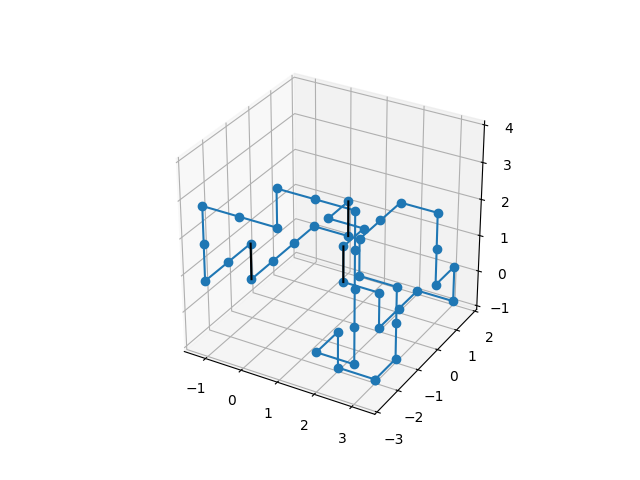

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
X,Y,Z = [],[],[]

# for cycle in GC.dict_blocked_edges[(62, 63)]:
A,B,C = [],[],[]
for point in cycle:
    x, y, z = G.mapping[point]
    A.append(x)
    B.append(y)
    C.append(z)
    ##########
    X.append(x)
    Y.append(y)
    Z.append(z)

ax.plot(A, B, C,marker = "o") 

Blockii_edges = []
for i in range(len(cycle)):
    edge = min(cycle[i],cycle[(i+1)%len(cycle)]),max(cycle[i],cycle[(i+1)%len(cycle)])
    if edge in G.blocked_edges:
        Blockii_edges.append(edge)
    
for edge in Blockii_edges:
    x,y,z = G.mapping[edge[0]]
    x1,y1,z1 = G.mapping[edge[1]]
    ax.plot([x,x1],[y,y1],[z,z1],color="black")


# origin = 180
# x,y,z = G.mapping[origin]
# ax.plot(x,y,z,color="black",marker="x")

X,Y,Z = np.array(X),np.array(Y),np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

In [48]:
G = GraphGrid3D(Edges,[])
GC = Graph_Cycles(Edges,Marked_edges)

100%|██████████| 600/600 [00:00<00:00, 3724.61it/s]
